In [38]:
import sys
sys.path.append("../")
from qmg.generator import MoleculeGenerator
from qmg.utils import ConditionalWeightsGenerator
from rdkit import RDLogger
import numpy as np
RDLogger.DisableLog('rdApp.*')

# parameter settings for epoxide derivatives
num_heavy_atom = 5
random_seed = 3
smarts = "[O:1]1[C:2][C:3]1"
disable_connectivity_position = [1]
num_sample = 10000

cwg = ConditionalWeightsGenerator(num_heavy_atom, smarts=smarts, disable_connectivity_position=disable_connectivity_position)
random_weight_vector = cwg.generate_conditional_random_weights(random_seed)
# mg = MoleculeGenerator(num_heavy_atom, all_weight_vector=random_weight_vector)
# smiles_dict, validity, diversity = mg.sample_molecule(num_sample)
# print(smiles_dict)
# print("Validity: {:.2f}%".format(validity*100))
# print("Diversity: {:.2f}%".format(diversity*100))

In [39]:
from rdkit import Chem
from rdkit.Chem import Descriptors

class FitnessCalculator():
    def __init__(self, task, distribution_learning=True):
        self.task = task
        self.distribution_learning = distribution_learning

    def calc_property(self, mol):
        if self.task == "qed":
            return Descriptors.qed(mol)

    def calc_score(self, smiles_dict: dict):
        total_count = 0
        property_sum = 0
        for smiles, count in smiles_dict.items():
            total_count += count
            mol = Chem.MolFromSmiles(str(smiles))
            if mol == None:
                continue
            else:
                property_sum += self.calc_property(mol) * count
        return property_sum / total_count

In [40]:
number_flexible_parameters = len(random_weight_vector[cwg.parameters_indicator == 0.])
print(cwg.parameters_value, cwg.parameters_indicator)
print(random_weight_vector)
print("Number of flexible parameters:", number_flexible_parameters)
print(random_weight_vector[cwg.parameters_indicator == 0.])
random_weight_vector[cwg.parameters_indicator == 0.] = np.random.rand(len(random_weight_vector[cwg.parameters_indicator == 0.]))
print(random_weight_vector)

[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
[1.         0.         0.         0.         1.         0.
 0.         1.         0.         1.         0.         1.
 1.         0.         0.         0.         0.         0.86804531
 0.52318121 0.74125186 0.         0.0301489  0.9698511  0.
 0.         0.01550588 0.93276362 0.23637454 0.85941196 0.8788128
 0.71412948 0.92109867 0.         0.31956348 0.05381312 0.62662339
 0.         0.         0.06798443 0.60849347 0.48274007 0.71808093
 0.31332415 0.6505131 ]
Number of flexible parameters: 21
[0.86804531 0.52318121 0.74125186 0.0301489  0.9698511  0.01550588
 0.93276362 0.23637454 0.85941196 0.8788128  0.71412948 0.92109867
 0.31956348 0.05381312 0.62662339 0.06798443 0.60849347 0.48274007
 0.71808093 0.31332415 0.65

In [41]:
cwg.apply_chemistry_constraint(random_weight_vector)

array([1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.75361125, 0.98979388, 0.67256097,
       0.        , 0.86537242, 0.13462758, 0.        , 0.        ,
       0.32914599, 0.67852294, 0.27162049, 0.74017845, 0.91277758,
       0.87680886, 0.95213127, 0.        , 0.20705831, 0.71377728,
       0.0791644 , 0.        , 0.        , 0.40473431, 0.75625601,
       0.35226029, 0.67425098, 0.11639247, 0.74241898])

In [47]:
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax import SearchSpace, ParameterType, RangeParameter
from ax.core.observation import ObservationFeatures
from ax.core.arm import Arm
import torch
torch.set_default_dtype(torch.float64)
fc = FitnessCalculator(task="qed")

######################## Generation Strategy ###################################
model_dict = {'MOO': Models.MOO, 'GPEI': Models.GPEI, 'SAASBO': Models.SAASBO,}
gs = GenerationStrategy(
    steps=[
#         only use this when there is no initial data
        GenerationStep(
        model=Models.SOBOL, 
        num_trials=5,
        max_parallelism=1,
        model_kwargs={"seed": 42}, 
        ),
        GenerationStep(
            model=model_dict['MOO'],
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=1,  # Parallelism limit for this step, often lower than for Sobol
            model_kwargs = {"torch_dtype": torch.float64, "torch_device": torch.device("cuda" if torch.cuda.is_available() else "cpu")},
            # !!!!!!!!!!!!!!!!!! Please use the above one for real suggestion, the below is jut for test
            # Make sure using the a number which can be divided by 16, or manually specify "thinning": 16 or other values
            #model_kwargs = {"num_samples": 16, "warmup_steps": 32, "gp_kernel": "matern"},
#             model_gen_kwargs = {"fixed_features": fixed_features, }
            # "matern" is better for zigzag function than 'rbf'
        ),
    ]
)
ax_client = AxClient(random_seed = 42, generation_strategy  = gs) # set the random seed for BO for reproducibility
#####################################################################################
# ax_client = AxClient()

ax_client.create_experiment(
    name="moo_experiment",
    parameters=[
        {
            "name": f"x{i+1}",
            "type": "range",
            "bounds": [0.0, 1.0],
        }
        for i in range(number_flexible_parameters)
    ],
    objectives={
        "qed": ObjectiveProperties(minimize=False,),
        "uniqueness": ObjectiveProperties(minimize=False,),
    },
    overwrite_existing_experiment=True,
    is_test=True,
)

def evaluate(parameters):
    partial_inputs = np.array([parameters.get(f"x{i+1}") for i in range(number_flexible_parameters)])
    inputs = random_weight_vector
    inputs[cwg.parameters_indicator == 0.] = partial_inputs
    # inputs = cwg.apply_chemistry_constraint(inputs)
    mg = MoleculeGenerator(num_heavy_atom, all_weight_vector=inputs)
    smiles_dict, validity, diversity = mg.sample_molecule(num_sample)
    # In our case, standard error is 0, since we are computing a synthetic function.
    # Set standard error to None if the noise level is unknown.
    return {"qed": (fc.calc_score(smiles_dict), None), "uniqueness": (diversity, None)}

[INFO 11-07 10:31:14] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 11-07 10:31:14] ax.service.ax_client: Random seed set to 42. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 11-07 10:31:14] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 11-07 10:31:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INF

In [48]:
for i in range(20):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

/beegfs/home/lungyi45/.conda/envs/qmg-n/lib/python3.12/site-packages/ax/modelbridge/cross_validation.py:463: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 11-07 10:31:17] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.997513, 'x2': 0.104366, 'x3': 0.822979, 'x4': 0.419432, 'x5': 0.528322, 'x6': 0.056241, 'x7': 0.455292, 'x8': 0.749203, 'x9': 0.221074, 'x10': 0.617698, 'x11': 0.810095, 'x12': 0.212291, 'x13': 0.038436, 'x14': 0.881824, 'x15': 0.65063, 'x16': 0.666585, 'x17': 0.820932, 'x18': 0.596579, 'x19': 0.236308, 'x20': 0.806974, 'x21': 0.167144} using model Sobol.


[INFO 11-07 10:31:19] ax.service.ax_client: Completed trial 0 with data: {'qed': (0.031431, None), 'uniqueness': (0.0045, None)}.
/beegfs/home/lungyi45/.conda/envs/qmg-n/lib/python3.12/site-packages/ax/modelbridge/cross_validation.py:463: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 11-07 10:31:19] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 0.028678, 'x2': 0.748257, 'x3': 0.112076, 'x4': 0.517183, 'x5': 0.034321, 'x6': 0.819032, 'x7': 0.563061, 'x8': 0.185619, 'x9': 0.744641, 'x10': 0.137562, 'x11': 0.213577, 'x12': 0.87748, 'x13': 0.680689, 'x14': 0.344031, 'x15': 0.21139, 'x16': 0.190914, 'x17': 0.43524, 'x18': 0.192179, 'x19': 0.595411, 'x20': 0.359438, 'x21': 0.627129} using model Sobol.
[INFO 11-07 10:31:20] ax.service.ax_client: Completed trial 1 with data: {'qed': (0.291486, None), 'uniqueness': (0.0042, None)}.
/beegfs/home/lungyi45/.conda/envs/qmg-n/lib/python3.12/site-packages

In [61]:
trial_df = ax_client.get_trials_data_frame()
trial_df['trial_index'] = trial_df['trial_index'] + 1
trial_df

[WARNING 11-07 10:39:22] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,qed,uniqueness,x1,x2,x3,x4,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21
0,1,0_0,COMPLETED,Sobol,0.031431,0.0045,0.997513,0.104366,0.822979,0.419432,...,0.212291,0.038436,0.881824,0.650630,0.666585,0.820932,0.596579,0.236308,0.806974,0.167144
1,2,1_0,COMPLETED,Sobol,0.291486,0.0042,0.028678,0.748257,0.112076,0.517183,...,0.877480,0.680689,0.344031,0.211390,0.190914,0.435240,0.192179,0.595411,0.359438,0.627129
2,3,2_0,COMPLETED,Sobol,0.281745,0.0066,0.401359,0.280010,0.504128,0.166136,...,0.509352,0.444765,0.564434,0.415810,0.916697,0.211550,0.752934,0.828111,0.507542,0.395155
3,4,3_0,COMPLETED,Sobol,0.047762,0.0045,0.619950,0.885082,0.308856,0.772432,...,0.330548,0.837089,0.163385,0.979988,0.440770,0.544606,0.411311,0.468466,0.076165,0.935222
4,5,4_0,COMPLETED,Sobol,0.260661,0.0028,0.634426,0.494315,0.165308,0.926446,...,0.453451,0.305754,0.454573,0.837993,0.349873,0.663296,0.367636,0.995604,0.968974,0.033604
5,6,5_0,COMPLETED,MOO,0.333104,0.0049,0.264569,0.414153,0.315896,0.150318,...,0.655097,0.507507,0.459784,0.398392,0.857276,0.289386,0.617844,0.871746,0.532484,0.395616
6,7,6_0,COMPLETED,MOO,0.323415,0.0053,0.224043,0.362009,0.359399,0.144743,...,0.710151,0.478488,0.476189,0.370616,0.880125,0.246676,0.670129,1.000000,0.574440,0.338093
7,8,7_0,COMPLETED,MOO,0.333598,0.0034,0.156491,0.439437,0.550144,0.252339,...,0.754974,0.502036,0.452306,0.339704,0.774173,0.288895,0.555782,0.937046,0.594294,0.335043
8,9,8_0,COMPLETED,MOO,0.304975,0.0039,0.080572,0.520323,0.000000,0.235819,...,0.819139,0.521837,0.343055,0.360012,0.802802,0.449926,0.771377,1.000000,0.632247,0.324066
9,10,9_0,COMPLETED,MOO,0.346764,0.0015,0.365693,0.344897,0.000000,0.224879,...,0.569391,0.464755,0.515832,0.331660,0.967971,0.266998,0.451470,0.875537,0.561588,0.357370


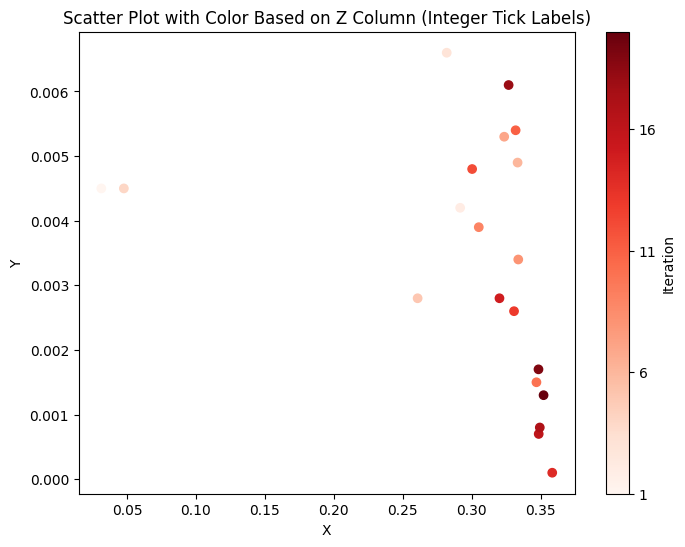

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Scatter plot with color based on 'z' column
plt.figure(figsize=(8, 6))
scatter = plt.scatter(trial_df['qed'], trial_df['uniqueness'], c=trial_df['trial_index'], cmap='Reds')

# Adding colorbar to indicate 'z' values
colorbar = plt.colorbar(scatter)
colorbar.set_label('Iteration')

# Setting colorbar ticks to integer values only
z_min, z_max = int(trial_df['trial_index'].min()), int(trial_df['trial_index'].max())
colorbar.set_ticks(np.arange(z_min, z_max + 1, step=5))  # Adjust step as needed for readability

# Adding labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Color Based on Z Column (Integer Tick Labels)')

# Show plot
plt.show()
